In [1]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import utils
from torch.utils.data import DataLoader
import tqdm as tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from utils import load_csv, drop_cols, remove_strings, groupedAvg, subsample, normalize
from create_dataset import AnimalDatasetEmbedding, UnpairedEmbeddingsDataset
from generators import  OneHotGenerator, SkipOneHotGenerator, SkipTensorEmbeddingGen, TensorEmbeddingGen, OneHotResNetGenerator
from discriminators import PatchDiscriminator, SampleDiscriminator
import os
import glob
import generators

/home/johann/anaconda3/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/johann/anaconda3/envs/pytorch/lib/python3.9/site-packages/torch/cuda/__init__.py:88: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1666642975993/work/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
# source = [1.06, 1.00, 0.93]
# # get mean and std of source
# print(np.mean(source))
# print(np.std(source))

# target = [1.08, 1.03, 0.92]
# # get mean and std of target
# print(np.mean(target))
# print(np.std(target))


In [72]:
# config
PHASES = [1,3]
UNPAIRED = True
SUPERVISED = False


UNET = True
SKIPCONNECTIONS = False 

RESNET = False

EMBEDDING = True           # Use intervention and phase information during training
if EMBEDDING == True:
    DOWN = True
    BOTTLENECK = False
ONEHOTENCODING = True

PATCH = True         # False = Patch Discriminator, True = Sample Discriminator
SMALLER_TARGET = False # True = train with target dataset size = PERCENTAGE
PERCENTAGE = 0.1       # percentage of target data


# LR scheduler
MultiStepLR = False
GAMMA = 0.1

ReduceLROnPlateau = False
FACTOR = 0.001
PATIENCE = 2

PolinomialLR = True
power = 1
LR_DECAY_AFTER_EPOCH = 100



DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16
LEARNING_RATE = 0.0002 #1e-2 
NUM_WORKERS = 16
NUM_EPOCHS = 200

SIG_A = "AoP"           # Drucksignal Hauptschlagader = Aortendruck
SIG_B = "VADcurrent"    # VAD Strom [A] – Pumpemstrom in Ampere
SIG_C = "VadQ"          # Fluss durch VAD (VAD = Ventrikular assistance device = Pumpe) = Pumpenfluss
SIG_D = "LVP"           # Ventrikeldruck links = Drucksignal der linken Herzkammer
TARGET = "LVtot_kalibriert"  # RVtot_kalibriert existiert auch
source_signals = [SIG_D]
CHANNELS = len(source_signals)
WINDOW = 256

GENERATION_AFTER_EPOCH = NUM_EPOCHS # number of epochs after which the model generates a sample

# Use adversarial loss
LAMBDA_DISC = 0.05
GAN_LOSS = True   # adversarial loss
LAMBDA_GAN = 1.0
# Use cycle consistency loss
CYCLE = True
LAMBDA_CYCLE = 1.0
# Use supervised loss
SUPERVISED = False
LAMBDA_SUPERVISED = 1.0
# Use Identity loss
IDENTITY = False
LAMBDA_IDENTITY = 10.0

### Load all data and preprocess

Subsamplen, normalisieren pro Datei

In [4]:
path = "/home/johann/Desktop/Uni/Masterarbeit/Cycle_GAN/csv_export_files_alle_Daten/csv_export_files" 
csv_files = glob.glob(os.path.join(path, "*.csv"))
  
df = pd.DataFrame()
scaler = StandardScaler() 
# loop over the list of csv files
for f in csv_files:
      
    # read the csv file
    df_temp = pd.read_csv(f, sep=";")
    df_temp = utils.drop_cols(df_temp)
    df_temp = df_temp.dropna()
    df_temp = utils.remove_strings(df_temp)
    df_temp = utils.subsample(df_temp, 10)
    df_temp = utils.normalize(df_temp, scaler, phase1 = True)  
      
    # print the content
    df = pd.concat([df, df_temp], axis=0)
    

print(df.shape)

(6022044, 14)


### Select part of data to use in experiment

In [5]:
# select which phases to use
df = df.loc[df['Phasenzuordnung'].isin(PHASES)]
print('Size of the dataset after selecting Phasenzuordnung 1',df.shape)

print('Size of the dataset with data from phase 1',df.shape)
print('Size of Phase 1: ', df.loc[df['Phasenzuordnung'] == 1].shape)
print('Size of Phase 2: ', df.loc[df['Phasenzuordnung'] == 2].shape)
print('Size of Phase 3: ', df.loc[df['Phasenzuordnung'] == 3].shape)
print('Size of Phase 4: ', df.loc[df['Phasenzuordnung'] == 4].shape)
print('SIze of Phase 5: ', df.loc[df['Phasenzuordnung'] == 5].shape)

Size of the dataset after selecting Phasenzuordnung 1 (2122212, 14)
Size of the dataset with data from phase 1 (2122212, 14)
Size of Phase 1:  (751120, 14)
Size of Phase 2:  (0, 14)
Size of Phase 3:  (1371092, 14)
Size of Phase 4:  (0, 14)
SIze of Phase 5:  (0, 14)


In [6]:
df = df.reset_index(drop=True)

for index, row in df.iterrows():
    if row['Phasenzuordnung'] == 1:
        df.at[index, 'intervention'] = 0
    elif row['intervention'] == 10:
        if row['contractility'] == 1.0:
            df.at[index, 'intervention'] = 0      # contractility = 1.0 - could be ignored? - phase 0?
        if row['contractility'] == 3.0:
            df.at[index, 'intervention'] = 5      # contractility = 3.0                                        
        if row['contractility'] == 4.0:
            df.at[index, 'intervention'] = 6      # contractility = 4.0

#get unique intervention
print(df['intervention'].unique())

int_1 = df.loc[df['intervention'] == 1]
int_2 = df.loc[df['intervention'] == 2]
int_3 = df.loc[df['intervention'] == 3]
int_4 = df.loc[df['intervention'] == 4]
int_5 = df.loc[df['intervention'] == 5]
int_6 = df.loc[df['intervention'] == 6]

print('Size of intervention 1: ', int_1.shape)
print('Size of intervention 2: ', int_2.shape)
print('Size of intervention 3: ', int_3.shape)
print('Size of intervention 4: ', int_4.shape)
print('Size of intervention 5: ', int_5.shape)
print('Size of intervention 6: ', int_6.shape)

#remove rows with intervention 2, 4 and 6, nearly no data
df = df[df.intervention != 2]
df = df[df.intervention != 4]
df = df[df.intervention != 5]
print(df['intervention'].unique())

[0. 1. 3. 6. 2. 4. 5.]
Size of intervention 1:  (553750, 14)
Size of intervention 2:  (9601, 14)
Size of intervention 3:  (522847, 14)
Size of intervention 4:  (12915, 14)
Size of intervention 5:  (8126, 14)
Size of intervention 6:  (217192, 14)
[0. 1. 3. 6.]


### Drop animals with less than 10 data points
We drop animals from the dataframe, if they have less than 10 data points. Initially, we have 56 animals and after dropping those with close to no data points, we are left with 25 animals

In [7]:
print(len(df['animal'].unique()))
# remove animals with less than 10 data points
df = df.groupby('animal').filter(lambda x: len(x) > 10)
print('Number of animals after removing those with less than 10 data points: ', len(df['animal'].unique()))

# get all differnent animals
animals = df['animal'].unique()
print(animals)

25
Number of animals after removing those with less than 10 data points:  25
[  8  12  13 108   7  14  11   2  16  10 105 111  17  19   3  15   5  20
 113   4 102   1   9 107 101]


### Split data into train and test split

The 5 test animals represent 20.20924% of the whole data. If we don't use all phases, this number might be different

In [8]:
# select animals 3,4,8,11,17 as test animals
test_animals = [3,4,8,11,17]
print('\nTest animal(s):', test_animals)

all_animals = df['animal'].unique()
# remove test animals from train animals
train_animals =  [x for x in all_animals if x not in test_animals]

# test data
df_test = df[df['animal'].isin(test_animals)]

# change the length of the test data to a multiple of the Window size
df_test = df_test.iloc[:len(df_test) - (len(df_test) % WINDOW)]

# train dataframe with only animals from train_animals
df_train = df[df['animal'].isin(train_animals)]
print('\nDifferent animal IDs after removing those that are in the test dataset: ',len(df_train['animal'].unique()))


print('\nTrain data shape:', df_train.shape)
print('\nTest data shape:', df_test.shape)

# lengt of df_train
print('\nThe test dataset is {} percent of the whole data: '.format((len(df_test)/(len(df_train) + len(df_test))) * 100))


Test animal(s): [3, 4, 8, 11, 17]

Different animal IDs after removing those that are in the test dataset:  20

Train data shape: (1484447, 14)

Test data shape: (606976, 14)

The test dataset is 29.022153815846913 percent of the whole data: 


### Create target dataframe with a fraction of dfs data

Option 1: 10% of data of each animal -> most likely no data from the last phases

Option 2: Take first 10% of data of each phase per animal

In [9]:
# get first 10% of data of each phase per animal
df_target = pd.DataFrame()

for animal in df_train['animal'].unique():
    for phase in df_train['Phasenzuordnung'].unique():
        df_temp = df_train.loc[(df_train['animal'] == animal) & (df_train['Phasenzuordnung'] == phase)]
        df_temp = df_temp.iloc[:int(len(df_temp)*PERCENTAGE)]
        df_target = pd.concat([df_target, df_temp], axis=0)

print('\nShape of df_target:', df_target.shape)
print('\nNumber of animals in df_target:', len(df_target['animal'].unique()))
print('\nNumber of phases in df_target:', len(df_target['Phasenzuordnung'].unique()))
print(df_train.shape[0] / df_target.shape[0])


Shape of df_target: (148429, 14)

Number of animals in df_target: 20

Number of phases in df_target: 2
10.001057744780333


/tmp/ipykernel_655113/1413311242.py:5: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.plot(df_target[TARGET][:1000])


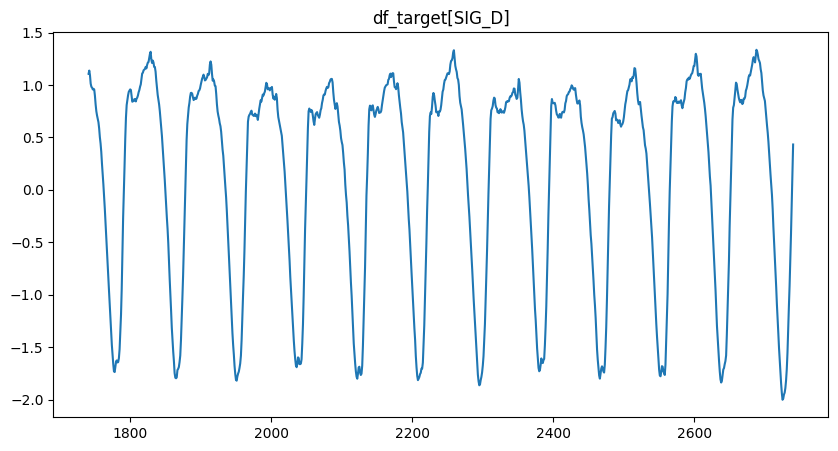

In [10]:
# plot df_target[SIG_D]

# plot df_target[SIG_D]
plt.figure(figsize=(10,5))
plt.plot(df_target[TARGET][:1000])
plt.title('df_target[SIG_D]')
plt.show()

#### Initialize Generator and Discriminator

We also initialize the 2 optimizers, the 2 Learning rate schedulers, the losses

In [11]:
# def double_conv_pad(in_channels, out_channels):
#     return nn.Sequential(
#         nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1, padding_mode='zeros'),
#         nn.BatchNorm1d(out_channels),
#         nn.LeakyReLU(inplace=True),
#         nn.Dropout1d(p=0.1, inplace=False),
#         nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1, padding_mode='zeros'),
#         nn.BatchNorm1d(out_channels),
#         nn.LeakyReLU(inplace=True),
#         nn.Dropout1d(p=0.1, inplace=False),
#     )


# class TensorEmbeddingGen(nn.Module):
#     def __init__(self, INPUTCHANNELS, OUTPUTCHANNELS, Down = True, Bottleneck = True):
#         super(TensorEmbeddingGen, self).__init__()
#         self.Down = Down
#         self.Bottleneck = Bottleneck
#         self.maxpool = nn.MaxPool1d((2))  

#         self.source_intervention = torch.nn.Embedding(num_embeddings=8, embedding_dim=256)
#         self.source_phase = torch.nn.Embedding(num_embeddings=7, embedding_dim=256)

#         self.down_conv1 = double_conv_pad(INPUTCHANNELS, 32) 
#         self.down_conv2 = double_conv_pad(32, 64) 
#         self.down_conv3 = double_conv_pad(64, 128)
#         self.down_conv4 = double_conv_pad(128, 256)

#         self.target_intervention = torch.nn.Embedding(num_embeddings=8, embedding_dim=32)
#         self.target_phase = torch.nn.Embedding(num_embeddings=7, embedding_dim=32)

#         self.up_trans1 = nn.ConvTranspose1d(256, 128, kernel_size=(2), stride=2, padding=0)
#         self.up_conv1 = double_conv_pad(128, 128)
#         self.up_trans2 = nn.ConvTranspose1d(128, 64, kernel_size=(2), stride=2, padding=0)
#         self.up_conv2 = double_conv_pad(64, 64)
#         self.up_trans3 = nn.ConvTranspose1d(64, 32, kernel_size=(2), stride=2, padding=0)
#         self.up_conv3 = double_conv_pad(32, 32)

#         self.out = nn.Conv1d(32, OUTPUTCHANNELS, kernel_size=1) # kernel_size must be == 1

#         self.apply(self._init_weights)
        
#     def _init_weights(self, module):
#         if isinstance(module, nn.Conv1d):
#             module.weight.data.normal_(mean=0.0, std=1)
#             if module.bias is not None:
#                 module.bias.data.zero_()
#         elif isinstance(module, nn.ConvTranspose1d):
#             module.weight.data.normal_(mean=0.0, std=1)
#             if module.bias is not None:
#                 module.bias.data.zero_()
#         elif isinstance(module, nn.Embedding):
#             module.weight.data.normal_(mean=0.0, std=1)
#         elif isinstance(module, nn.BatchNorm1d):
#             module.weight.data.normal_(mean=0.0, std=1)
#             if module.bias is not None:
#                 module.bias.data.zero_()
#         elif isinstance(module, nn.Linear):
#             module.weight.data.normal_(mean=0.0, std=1)
#             if module.bias is not None:
#                 module.bias.data.zero_()

#     def forward(self, input, source_phase, source_intervention, target_phase, target_intervention):
#         if self.Down:
#             print(input.shape)
#             sp = self.source_phase(source_phase)
#             print(sp.shape)
#             si = self.source_intervention(source_intervention)
#             print(si.shape)
#             input = input + sp + si 
#         x1 = self.down_conv1(input) 
#         x2 = self.maxpool(x1) 
#         x3 = self.down_conv2(x2)
#         x4 = self.maxpool(x3) 
#         x5 = self.down_conv3(x4) 
#         x6 = self.maxpool(x5)  
#         x7 = self.down_conv4(x6)

#         # # decoder
#         if self.Bottleneck:
#             tp = self.target_phase(target_phase)  
#             ti = self.target_intervention(target_intervention)
#             x7 = x7 + tp + ti # target embeddings are added before upsampling  # lieber concatenating und dann fully connected to amtch the dimension
#         x = self.up_trans1(x7)
#         x = self.up_conv1(x)
#         x = self.up_trans2(x)
#         x = self.up_conv2(x)
#         x = self.up_trans3(x)
#         x = self.up_conv3(x)
#         x = self.out(x)

#         return x

In [12]:
def Conv_block(in_channels, out_channels, kernel_size , stride):
    return nn.Sequential(
        nn.Conv1d(in_channels, out_channels, kernel_size, stride),
        nn.BatchNorm1d(out_channels),
        nn.LeakyReLU(inplace=False),
        nn.Dropout1d(p=0.1, inplace=False),
    )

def Conv_block_no_norm(in_channels, out_channels, kernel_size , stride):
    return nn.Sequential(
        nn.Conv1d(in_channels, out_channels, kernel_size, stride),
        #nn.BatchNorm1d(out_channels),
        nn.LeakyReLU(inplace=False),
        nn.Dropout1d(p=0.1, inplace=False),
    )

class SampleDiscriminator(nn.Module):
    def __init__(self, CHANNELS):
        super(SampleDiscriminator, self).__init__()

        
        self.conv1 = Conv_block(in_channels= CHANNELS, out_channels= 32, kernel_size = 4, stride = 3) 
        self.conv2 = Conv_block(in_channels= 32, out_channels= 64, kernel_size = 4, stride = 3)       
        self.conv3 = Conv_block(in_channels= 64, out_channels= 128, kernel_size = 4, stride = 3)      
        self.conv4 = Conv_block(in_channels= 128, out_channels= 256, kernel_size = 3, stride = 2)     
        self.conv5 = Conv_block_no_norm(in_channels= 256, out_channels= 1, kernel_size = 4, stride = 2) 
        
        self.out = nn.Sigmoid()             


    # input shape
    # torch.Size([1, 1, 256])
    # torch.Size([1, 32, 85])
    # torch.Size([1, 64, 28])
    # torch.Size([1, 128, 9])
    # torch.Size([1, 256, 4])
    # torch.Size([1, 1, 1])
    # torch.Size([1, 1, 1])

    def forward(self, input):    
        # input: torch.Size([1, 1, 256]) 
        x = self.conv1(input)  # torch.Size([1, 32, 85])       
        x = self.conv2(x)      # torch.Size([1, 64, 28])     
        x = self.conv3(x)      # torch.Size([1, 128, 9])      
        x = self.conv4(x)      # torch.Size([1, 256, 4]) 
        x = self.conv5(x)      # torch.Size([1, 1, 1])     
        x = self.out(x)        # torch.Size([1, 1, 1])     
        return x

In [73]:
# Generator
if UNET:
    if ONEHOTENCODING and not SKIPCONNECTIONS:
        gen_target = OneHotGenerator(INPUTCHANNELS = CHANNELS, OUTPUTCHANNELS = 1, WINDOWSIZE=WINDOW, Down = DOWN, Bottleneck=BOTTLENECK).to(DEVICE)
        gen_source = OneHotGenerator(INPUTCHANNELS = 1, OUTPUTCHANNELS = CHANNELS, WINDOWSIZE=WINDOW, Down = DOWN, Bottleneck=BOTTLENECK).to(DEVICE)

    # if ONEHOTENCODING and SKIPCONNECTIONS:
    #     gen_target = SkipOneHotGenerator(INPUTCHANNELS = CHANNELS, OUTPUTCHANNELS = 1, WINDOWSIZE=WINDOW, Down = DOWN, Bottleneck=BOTTLENECK).to(DEVICE)
    #     gen_source = SkipOneHotGenerator(INPUTCHANNELS = 1, OUTPUTCHANNELS = CHANNELS, WINDOWSIZE=WINDOW, Down = DOWN, Bottleneck=BOTTLENECK).to(DEVICE)

    # if not ONEHOTENCODING and SKIPCONNECTIONS:
    #     gen_target = SkipTensorEmbeddingGen(INPUTCHANNELS = CHANNELS, OUTPUTCHANNELS = 1, Down = DOWN, Bottleneck=BOTTLENECK).to(DEVICE)
    #     gen_source = SkipTensorEmbeddingGen(INPUTCHANNELS = 1, OUTPUTCHANNELS = CHANNELS, Down = DOWN, Bottleneck=BOTTLENECK).to(DEVICE)

    # if not ONEHOTENCODING and not SKIPCONNECTIONS:
    #     gen_target = TensorEmbeddingGen(INPUTCHANNELS = CHANNELS, OUTPUTCHANNELS = 1, Down = DOWN, Bottleneck=BOTTLENECK).to(DEVICE)
    #     gen_source = TensorEmbeddingGen(INPUTCHANNELS = 1, OUTPUTCHANNELS = CHANNELS, Down = DOWN, Bottleneck=BOTTLENECK).to(DEVICE)

if not UNET:
    if ONEHOTENCODING:
        gen_target = OneHotResNetGenerator(INPUTCHANNELS = CHANNELS, OUTPUTCHANNELS= 1, WINDOWSIZE = WINDOW, blocks=6, Down = False, Bottleneck = True)
        gen_source = OneHotResNetGenerator(INPUTCHANNELS = 1, OUTPUTCHANNELS= CHANNELS, WINDOWSIZE = WINDOW, blocks=6, Down = False, Bottleneck = True)


# Discriminator
if PATCH:
    disc_target = PatchDiscriminator(CHANNELS = 1).to(DEVICE)
    disc_source = PatchDiscriminator(CHANNELS = CHANNELS).to(DEVICE)
if not PATCH:
    disc_target = SampleDiscriminator(CHANNELS = 1).to(DEVICE)
    disc_source = SampleDiscriminator(CHANNELS = CHANNELS).to(DEVICE)

# Optimizers 
opt_disc = torch.optim.AdamW(                                         
    list(disc_source.parameters()) + list(disc_target.parameters()), 
    lr=LEARNING_RATE, 
)
opt_gen = torch.optim.AdamW(
    list(gen_source.parameters()) + list(gen_target.parameters()),
    lr=LEARNING_RATE,
)

# Scheduler
if ReduceLROnPlateau:
    gen_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer = opt_gen,
                                                           factor=FACTOR, patience=PATIENCE, threshold=1e-4,
                                                           min_lr=1e-6,
                                                    )
    disc_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer = opt_disc,
                                                            factor=FACTOR, patience=PATIENCE, threshold=1e-4,
                                                            min_lr=1e-6,
                                                    )
if MultiStepLR:
    gen_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer = opt_gen, milestones=[5,6,7,8], gamma=GAMMA)
                                                        
    disc_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer = opt_disc, milestones=[5,6,7,8], gamma=GAMMA)

if PolinomialLR:
    gen_scheduler = torch.optim.lr_scheduler.PolynomialLR(optimizer = opt_gen,
                                                      total_iters = NUM_EPOCHS-LR_DECAY_AFTER_EPOCH, 
                                                      power = power,
                                                    )
    disc_scheduler = torch.optim.lr_scheduler.PolynomialLR(optimizer = opt_disc,
                                                       total_iters = NUM_EPOCHS-LR_DECAY_AFTER_EPOCH, 
                                                       power = power,
                                                    )

# losses
l1 = nn.L1Loss() 
mse = nn.MSELoss() 

#### Create the dataset and DataLoader

In [74]:
class UnequalDataSetSize(torch.utils.data.Dataset):
    def __init__(self, df, target_df, feature_names, target_name, window_length=256):
        self.df = df
        self.feature_names = feature_names
        self.target_name = target_name
        self.window_length = window_length
        self.target_df = target_df
        
        self.num_animals = len(np.unique(df["animal"]))
        self.animal_dfs = [group[1] for group in df.groupby("animal")]
        # get statistics for test dataset
        self.animal_lens = [len(an_df) // self.window_length for an_df in self.animal_dfs]
        self.animal_cumsum = np.cumsum(self.animal_lens)
        self.num_windows = sum(self.animal_lens)

        

    def __len__(self):
        return self.num_windows
    
    def __getitem__(self, idx):

        animal_idx = int(np.where(self.animal_cumsum >= idx)[0][0])
        animal_df = self.animal_dfs[animal_idx]

        # take different windows for the source and target -> unpaired examples
        start_idx_source = np.random.randint(0, len(animal_df) - self.window_length - 1)
        start_idx_target = np.random.randint(0, len(self.target_df) - self.window_length - 1)
        end_idx_source = start_idx_source + self.window_length
        end_idx_target = start_idx_target + self.window_length
        animal_df_source = animal_df.iloc[start_idx_source: end_idx_source]
        animal_df_target = self.target_df.iloc[start_idx_target: end_idx_target]

        # extract features
        input_df = animal_df_source[self.feature_names]
        target_df = animal_df_target[self.target_name]
        phase_df_source = animal_df_source["Phasenzuordnung"]   # mit 'Phasenzuordnung' klappt es
        intervention_df_source = animal_df_source["intervention"]
        phase_df_target = animal_df_target["Phasenzuordnung"]
        intervention_df_target = animal_df_target["intervention"]

        # to torch
        inputs = torch.tensor(input_df.to_numpy()).permute(1, 0)
        targets = torch.tensor(target_df.to_numpy()).unsqueeze(0)
        phase_source = torch.tensor(phase_df_source.to_numpy()).type(torch.LongTensor)
        intervention_source = torch.tensor(intervention_df_source.to_numpy()).type(torch.LongTensor)
        phase_target = torch.tensor(phase_df_target.to_numpy()).type(torch.LongTensor)
        intervention_target = torch.tensor(intervention_df_target.to_numpy()).type(torch.LongTensor)

        return inputs, targets, phase_source, intervention_source, phase_target, intervention_target

In [75]:
if not SMALLER_TARGET and UNPAIRED and EMBEDDING:
    # create dataset with information of the phases and intervention (embedding information)
    train_dataset = UnpairedEmbeddingsDataset(df_train, source_signals, target_name = TARGET, window_length = WINDOW)
    test_dataset = AnimalDatasetEmbedding(df_test, source_signals, target_name = TARGET, window_length = WINDOW)

# if not SMALLER_TARGET and not UNPAIRED and EMBEDDING:
#     train_dataset = AnimalDatasetEmbedding(df_train, source_signals, target_name = TARGET,  window_length = WINDOW)
#     test_dataset = AnimalDatasetEmbedding(df_test, source_signals, target_name = TARGET, window_length = WINDOW)

# if SMALLER_TARGET and UNPAIRED and EMBEDDING:
#     train_dataset = UnequalDataSetSize(df_train, df_target, source_signals, target_name = TARGET, window_length=WINDOW)
#     #test_dataset = UnequalDataSetSize(df_test, df_target, source_signals, target_name = TARGET, window_length=WINDOW)
#     test_dataset = AnimalDatasetEmbedding(df_test, source_signals, target_name = TARGET, window_length = WINDOW)


if SUPERVISED:
    train_dataset = AnimalDatasetEmbedding(df_target, source_signals, target_name = TARGET,  window_length = WINDOW)
    test_dataset = AnimalDatasetEmbedding(df_test, source_signals, target_name = TARGET, window_length = WINDOW)



# Data loader
loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True,)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True,)

#### Initialize weights and bias

In [76]:
# import wandb

# # start a new wandb run to track this script
# wandb.init(
#     # set the wandb project where this run will be logged
#     project="Cycle_GAN",
    
#     # track hyperparameters and run metadata
#     config={
#     "learning_rate": LEARNING_RATE,
#     "epochs": NUM_EPOCHS,
#     }
# )

In [77]:
def gen_signals(fake_target, fake_source, target, source):
    fake_target = fake_target.reshape(-1)
    fake_source = fake_source.reshape(-1)
    source = source.reshape(-1)
    target = target.reshape(-1)

    fig, ax = plt.subplots(2, 1, figsize=(10, 8))
    ax[0].plot(source.cpu().detach().numpy(), label= 'Real source signals')
    ax[0].plot(fake_source.cpu().detach().numpy(), label= 'Recreated source signals')
    ax[0].set_xlabel('Signal length')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    ax[1].plot(target.cpu().detach().numpy(), label= 'Real target signal')
    ax[1].plot(fake_target.cpu().detach().numpy(), label= 'Recreated target signal')
    ax[1].set_xlabel('Signal length')
    ax[1].set_ylabel('Loss')
    ax[1].legend()

def discriminator_loss(disc, reals, fakes):
    # calculate how close reals are to being classified as real
    real_loss = mse(disc(reals), torch.ones_like(disc(reals)))
    # calculate how close fakes are to being classified as fake
    fake_loss = mse(disc(fakes), torch.zeros_like(disc(fakes)))
    # return the average of real and fake loss
    return (real_loss + fake_loss) 


# @torch.cuda.amp.autocast()
def get_disc_loss(source, target, disc_source, disc_target, fake_source, fake_target
                    ):
    """
    Return the loss of the discriminator given inputs.
    """
    
    # discriminator loss
    disc_target_loss = discriminator_loss(disc_target, target, fake_target) * LAMBDA_DISC
    disc_source_loss = discriminator_loss(disc_source, source, fake_source) * LAMBDA_DISC
    disc_loss = (disc_source_loss + disc_target_loss) #/ 2

    return disc_loss, disc_source_loss, disc_target_loss

# @torch.cuda.amp.autocast()
def calc_gen_loss(source, target, source_phase, source_intervention, target_phase, target_intervention,
                  gen_source, gen_target, disc_source, disc_target, fake_target, fake_source
                  ):
    loss = 0


    if GAN_LOSS:
        g_source_loss = mse(disc_source(fake_source), torch.ones_like(disc_source(fake_source))) 
        g_target_loss = mse(disc_target(fake_target), torch.ones_like(disc_target(fake_target))) 

        loss += g_source_loss * LAMBDA_GAN + g_target_loss * LAMBDA_GAN
    else:
        g_source_loss = torch.tensor(0)
        g_target_loss = torch.tensor(0)

    if CYCLE:
        rec_target = gen_target(fake_source, source_phase, source_intervention, target_phase, target_intervention)
        rec_source = gen_source(fake_target, source_phase, source_intervention, target_phase, target_intervention)
        cycle_target_loss = l1(target, rec_target)  # l1 loss: Mean absolute error between each element in the input x and target y
        cycle_source_loss = l1(source, rec_source)  # l1 loss in cycle GAN paper

        loss += cycle_target_loss * LAMBDA_CYCLE + cycle_source_loss * LAMBDA_CYCLE
    else:
        cycle_target_loss = torch.tensor(0)
        cycle_source_loss = torch.tensor(0)

    if SUPERVISED:
        sup_source_loss = mse(source, fake_source)
        sup_target_loss = mse(target, fake_target)

        loss += sup_source_loss * LAMBDA_SUPERVISED + sup_target_loss * LAMBDA_SUPERVISED
    else:
        sup_source_loss = torch.tensor(0)
        sup_target_loss = torch.tensor(0)

    if IDENTITY:
        id_target_loss = l1(target, gen_target(target, source_phase, source_intervention, target_phase, target_intervention))
        id_source_loss = l1(source, gen_source(source, source_phase, source_intervention, target_phase, target_intervention))

        loss += id_target_loss * LAMBDA_IDENTITY + id_source_loss * LAMBDA_IDENTITY
    else:
        id_target_loss = torch.tensor(0)
        id_source_loss = torch.tensor(0)

    return loss, g_source_loss, g_target_loss, cycle_target_loss, cycle_source_loss, id_target_loss, id_source_loss, sup_source_loss, sup_target_loss

## Training

In [78]:
# training loop
from tqdm.auto import tqdm

for epoch in tqdm(range(NUM_EPOCHS)):

    for source, target, source_phase, source_intervention, target_phase, target_intervention in loader:
        # convert to float16
        source = source.float() # neccessary to prevent error: "Input type (torch.cuda.DoubleTensor) 
        target = target.float() # and weight type (torch.cuda.HalfTensor) should be the same"
    
        # move to GPU
        source = source.to(DEVICE)
        target = target.to(DEVICE)
        source_phase = source_phase.to(DEVICE)
        source_intervention = source_intervention.to(DEVICE)
        target_phase = target_phase.to(DEVICE)
        target_intervention = target_intervention.to(DEVICE)

        #  ------------------------------- #
        #  ----- train discriminators ---- #
        #  ------------------------------- #
        with torch.no_grad():
            fake_target = gen_target(source, source_phase, source_intervention, target_phase, target_intervention).detach()
            fake_source = gen_source(target, source_phase, source_intervention, target_phase, target_intervention).detach()

        d_loss, disc_source_loss, disc_target_loss = get_disc_loss(source, target, disc_source, disc_target, fake_source, fake_target)
                                                        # source, target, disc_source, disc_target, fake_source, fake_target

        # update gradients of discriminator 
        opt_disc.zero_grad() 
        d_loss.backward()
        opt_disc.step()
        # d_scaler.scale(d_loss).backward()  
               

        # -------------------------------- #
        # ------- train generators ------- #
        # -------------------------------- # 

        out = calc_gen_loss(source, target, source_phase, source_intervention, target_phase, target_intervention,
                                gen_source, gen_target, disc_source, disc_target, fake_target, fake_source)
                            # source, target, source_phase, source_intervention, target_phase, target_intervention,
                            # gen_source, gen_target, disc_source, disc_target, fake_target, fake_source

        g_loss, g_source_loss, g_target_loss, cycle_target_loss, cycle_source_loss, id_target_loss, id_source_loss, sup_source_loss, sup_target_loss = out
        # loss, g_source_loss, g_target_loss, cycle_target_loss, cycle_source_loss, id_target_loss, id_source_loss, sup_source_loss, sup_target_loss

        # update gradients of generator
        opt_gen.zero_grad()
        g_loss.backward()
        opt_gen.step()
        # g_scaler.scale(g_loss).backward()

    # Optimizer step
    # d_scaler.step(opt_disc)  
    # d_scaler.update()

    # g_scaler.step(opt_gen) 
    # g_scaler.update()

    # wandb.log({'Train/Discriminator source loss': disc_source_loss.item(),
    #             'Train/Discriminator target loss': disc_target_loss.item(),
    #             'Train/Total Discriminator loss': d_loss.item(),
    #             'Train/Total Generator loss': g_loss.item(),
    #             'Train/Adversarial loss source': g_source_loss.item(),
    #             'Train/Adversarial loss target': g_target_loss.item(),
    #             'Train/Cycle consistency loss source': cycle_source_loss.item(),
    #             'Train/Cycle consistency loss target': cycle_target_loss.item(),
    #             'Train/Supervised loss source': sup_source_loss.item(),
    #             'Train/Supervised loss target': sup_target_loss.item(),
    #             'Learning rate': opt_gen.param_groups[0]["lr"],
    #             # 'Train/Identity loss A': id_A_loss.item(),
    #             # 'Train/Identity loss B': id_B_loss.item()
    #             })
        

    # ------------------------ #
    # ------ Validation ------ #
    # ------------------------ #

    # source_losses = []
    # target_losses = []
    if (epoch+1) % 200 == 0:

        with torch.no_grad():
            # set models to evaluation mode
            disc_source.eval()  # set discriminator to evaluation mode
            disc_target.eval()  # turns off Dropouts Layers, BatchNorm Layers etc
            gen_target.eval()
            gen_source.eval()

            for source, target, source_phase, source_intervention, target_phase, target_intervention in test_loader:
                # convert to float16
                source = source.float()
                target = target.float()

                # move to GPU
                source = source.to(DEVICE)
                target = target.to(DEVICE)
                source_phase = source_phase.to(DEVICE)
                source_intervention = source_intervention.to(DEVICE)
                target_phase = target_phase.to(DEVICE)
                target_intervention = target_intervention.to(DEVICE)


                fake_target = gen_target(source, source_phase, source_intervention, target_phase, target_intervention).detach() # already torch.no_grad()
                fake_source = gen_source(target, source_phase, source_intervention, target_phase, target_intervention).detach()

                # Get validation loss
                l1_source = l1(source, fake_source)
                l1_target = l1(target, fake_target)
                # source_losses.append(l1_source.item())
                # target_losses.append(l1_target.item())

                
                # generate signals during validation
                #gen_signals(fake_target, fake_source, target, source)

                # calculate l1 loss of fake signals and real signals
                # test_real_fake_lossB = l1(target, fake_target)   # l1(sig_B, fake_B)
                # test_real_fake_lossA = l1(source, fake_source)

                #  ------------------------------- #
                #  ----- test discriminators ----- #
                #  ------------------------------- #

                test_d_loss, test_disc_A_loss, test_disc_B_loss = get_disc_loss(source, target, disc_source, disc_target, fake_source, fake_target)
                
                # -------------------------------- #
                # ------- test generators -------- #
                # -------------------------------- # 

                out = calc_gen_loss(source, target, source_phase, source_intervention, target_phase, target_intervention,
                                gen_source, gen_target, disc_source, disc_target, 
                                fake_target, fake_source
                                )
                g_lossT, g_A_lossT, g_B_lossT, cycle_B_lossT, cycle_A_lossT, id_B_lossT, id_A_lossT, sup_A_lossT, sup_B_lossT = out
        
                # gen_signals(fake_target, fake_source, target, source)

            # wandb.log({'Test/Generator loss': g_lossT.item(),
            #             'Test/Discriminator loss': test_d_loss.item(),
            #             'Test/L1 loss between real signal A and fake signals A': l1_source.item(),
            #             'Test/L1 loss between real signal B and fake signals B': l1_target.item(),
            #             'Test/Discriminator A loss': test_disc_A_loss.item(),
            #             'Test/Discriminator B loss': test_disc_B_loss.item(),
            #             'Test/Adversarial or GAN loss A': g_A_lossT.item(),
            #             'Test/Adversarial or GAN loss B': g_B_lossT.item(),
            #             'Test/Cycle consistency loss A': cycle_A_lossT.item(),
            #             'Test/Cycle consistency loss B': cycle_B_lossT.item(),
            #             'Test/Supervised loss A': sup_A_lossT.item(),
            #             'Test/Supervised loss B': sup_B_lossT.item(),
            #             'Test/Epoch': epoch+1,
            #     })      

    if ReduceLROnPlateau == True:  
        disc_scheduler.step(d_loss)
        gen_scheduler.step(g_loss)

    # scheduler step if epoch > LR_DECAY_AFTER_EPOCH
    if PolinomialLR == True and (epoch+1) >= LR_DECAY_AFTER_EPOCH:
        disc_scheduler.step()
        gen_scheduler.step()

    

100%|██████████| 200/200 [1:54:31<00:00, 34.36s/it]


### Get losses of the training run

In [79]:
source_losses = []
target_losses = []

disc_source.eval()  # set discriminator to evaluation mode
disc_target.eval()  # turns off Dropouts Layers, BatchNorm Layers etc
gen_target.eval()
gen_source.eval()

for source, target, source_phase, source_intervention, target_phase, target_intervention in test_loader:                
                    
    source = source.float()
    target = target.float()
    source = source.to(DEVICE)
    target = target.to(DEVICE)
    source_phase = source_phase.to(DEVICE)
    source_intervention = source_intervention.to(DEVICE)
    target_phase = target_phase.to(DEVICE)
    target_intervention = target_intervention.to(DEVICE)

    fake_target = gen_target(source, source_phase, source_intervention, target_phase, target_intervention)
    fake_source = gen_source(target, source_phase, source_intervention, target_phase, target_intervention)
    # source_reconstructed = gen_source(gen_target(source, source_phase, source_intervention, target_phase, target_intervention), source_phase, source_intervention, target_phase, target_intervention)
    # target_reconstructed = gen_target(gen_source(target, source_phase, source_intervention, target_phase, target_intervention), source_phase, source_intervention, target_phase, target_intervention)
    # l1_source = l1(source, fake_source)
    # l1_target = l1(target, fake_target)
    l1_source = l1(source, fake_source)
    l1_target = l1(target, fake_target)
    source_losses.append(l1_source.item())
    target_losses.append(l1_target.item())

print(f"Average L1 loss of source signals: {np.mean(source_losses)}")
print(f"Average L1 loss of target signals: {np.mean(target_losses)}")

# get min and max of losses
min_max_loss_source = np.min(source_losses), np.max(source_losses)
min_max_loss_target = np.min(target_losses), np.max(target_losses)
print(f"Min and max loss of source signals: {min_max_loss_source}")
print(f"Min and max loss of target signals: {min_max_loss_target}")

# get median of losses
median_loss_source = np.median(source_losses)
median_loss_target = np.median(target_losses)
print(f"Median loss of source signals: {median_loss_source}")
print(f"Median loss of target signals: {median_loss_target}")

Average L1 loss of source signals: 1.1067698980505403
Average L1 loss of target signals: 1.0575508636397284
Min and max loss of source signals: (0.7734475135803223, 1.389025330543518)
Min and max loss of target signals: (0.8173283338546753, 1.3159444332122803)
Median loss of source signals: 1.1059988141059875
Median loss of target signals: 1.0599060654640198


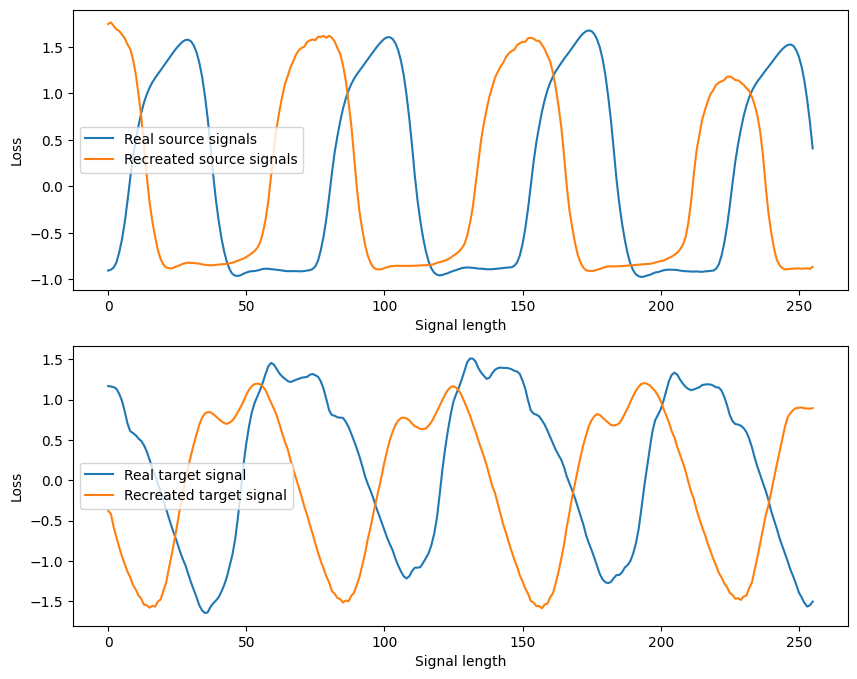

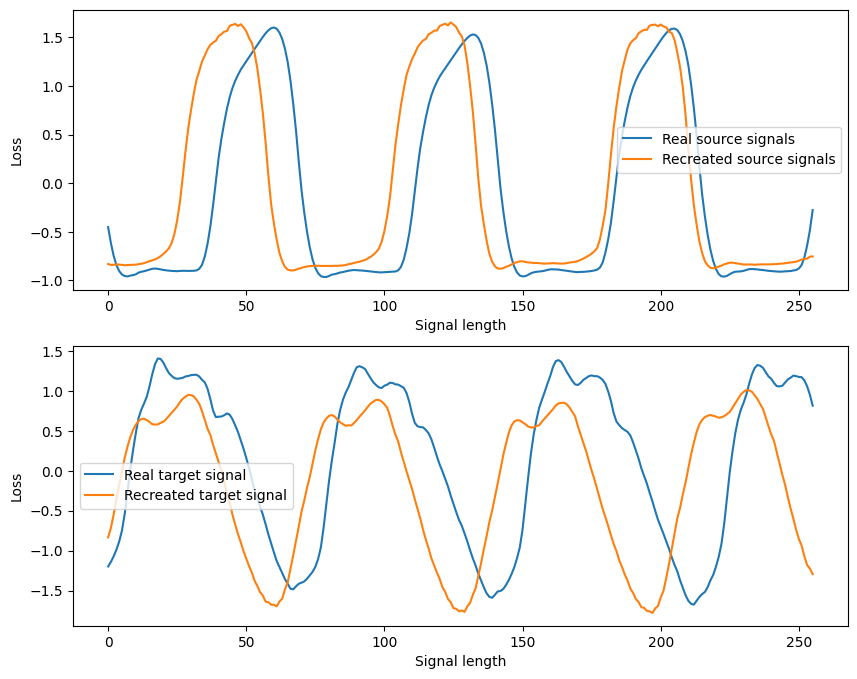

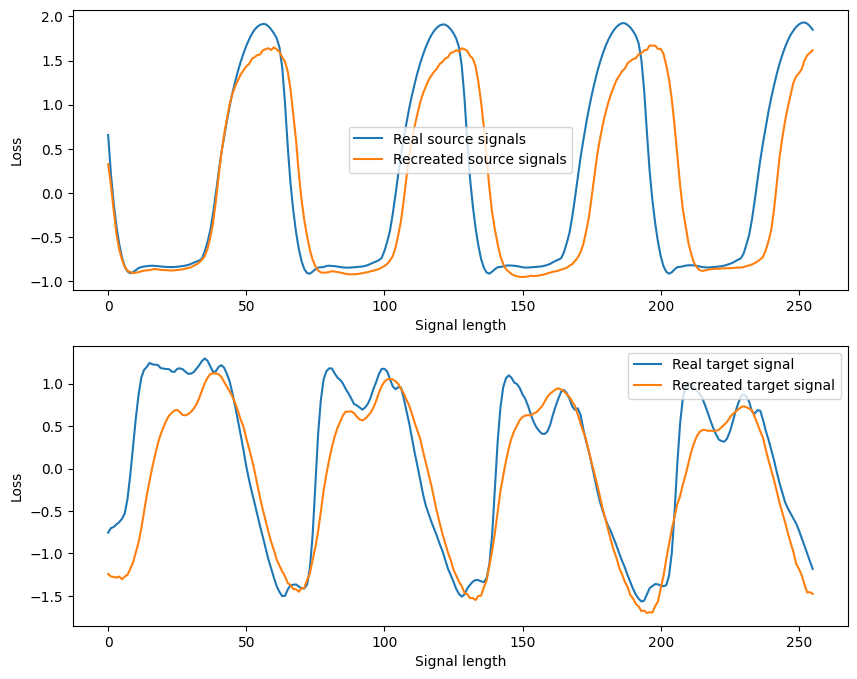

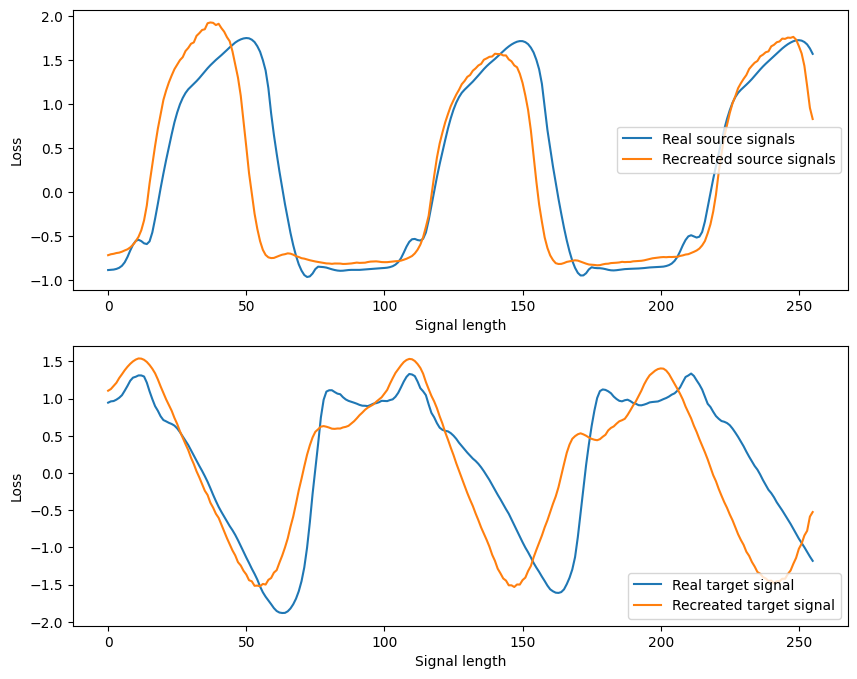

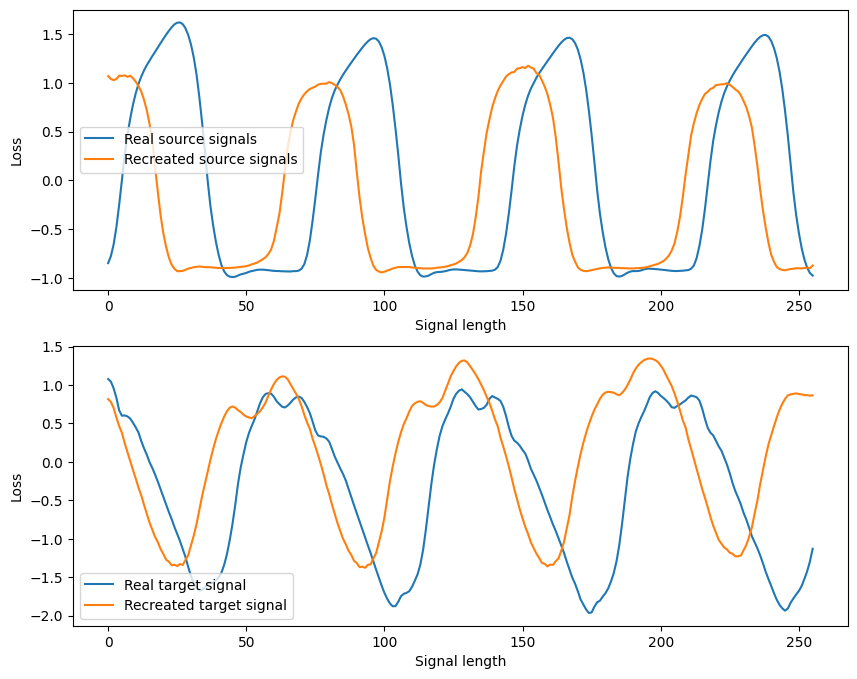

In [80]:
#  Generate signals
idx = 0
for source, target, source_phase, source_intervention, target_phase, target_intervention in test_loader:
    if idx == 5:
        break              
                    
    source = source.float()
    target = target.float()
    source = source.to(DEVICE)
    target = target.to(DEVICE)
    source_phase = source_phase.to(DEVICE)
    source_intervention = source_intervention.to(DEVICE)
    target_phase = target_phase.to(DEVICE)
    target_intervention = target_intervention.to(DEVICE)

    fake_target = gen_target(source, source_phase, source_intervention, target_phase, target_intervention)
    fake_source = gen_source(target, source_phase, source_intervention, target_phase, target_intervention)
                        
    fake_target = fake_target.reshape(-1)
    fake_source = fake_source.reshape(-1)
    source = source.reshape(-1)
    target = target.reshape(-1)

    fig, ax = plt.subplots(2, 1, figsize=(10, 8))
    ax[0].plot(source[:256].cpu().detach().numpy(), label= 'Real source signals')
    ax[0].plot(fake_source[:256].cpu().detach().numpy(), label= 'Recreated source signals')
    ax[0].set_xlabel('Signal length')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    ax[1].plot(target[:256].cpu().detach().numpy(), label= 'Real target signal')
    ax[1].plot(fake_target[:256].cpu().detach().numpy(), label= 'Recreated target signal')
    ax[1].set_xlabel('Signal length')
    ax[1].set_ylabel('Loss')
    ax[1].legend()

    idx += 1    

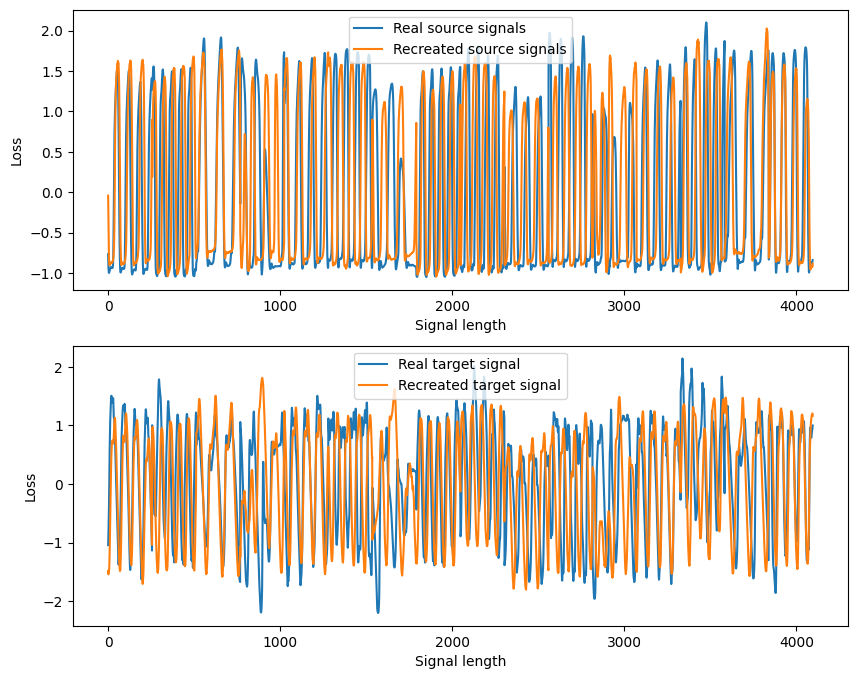

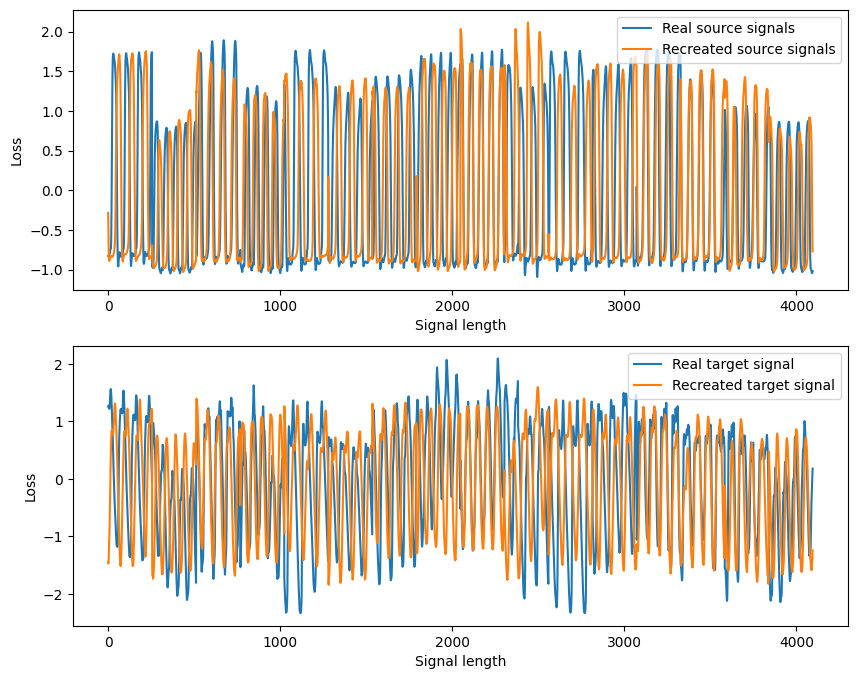

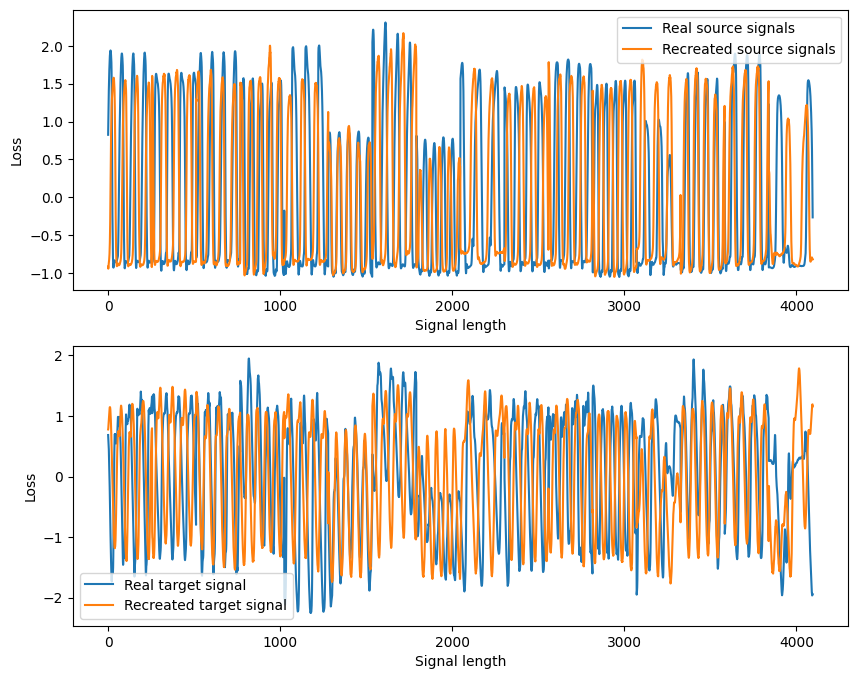

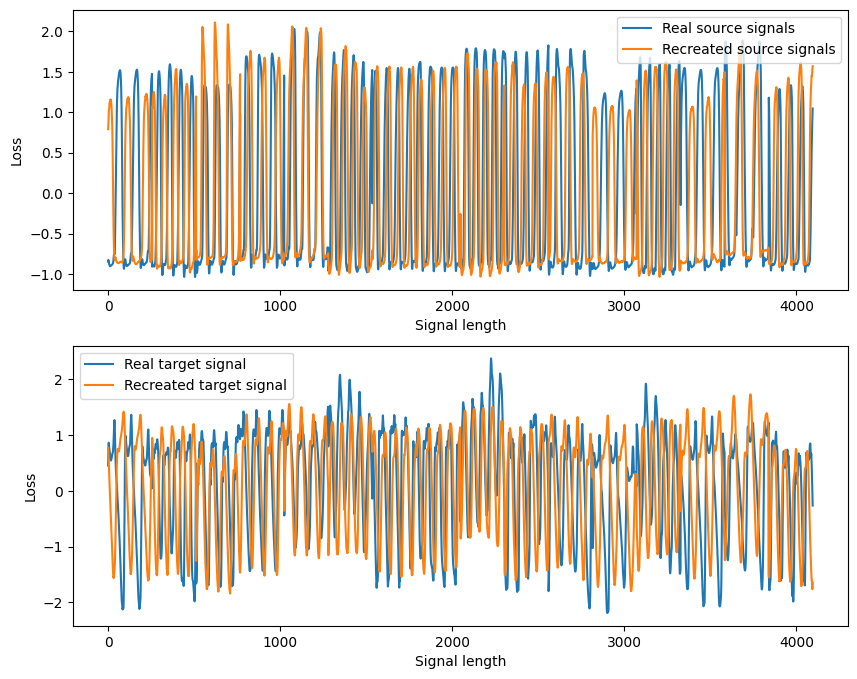

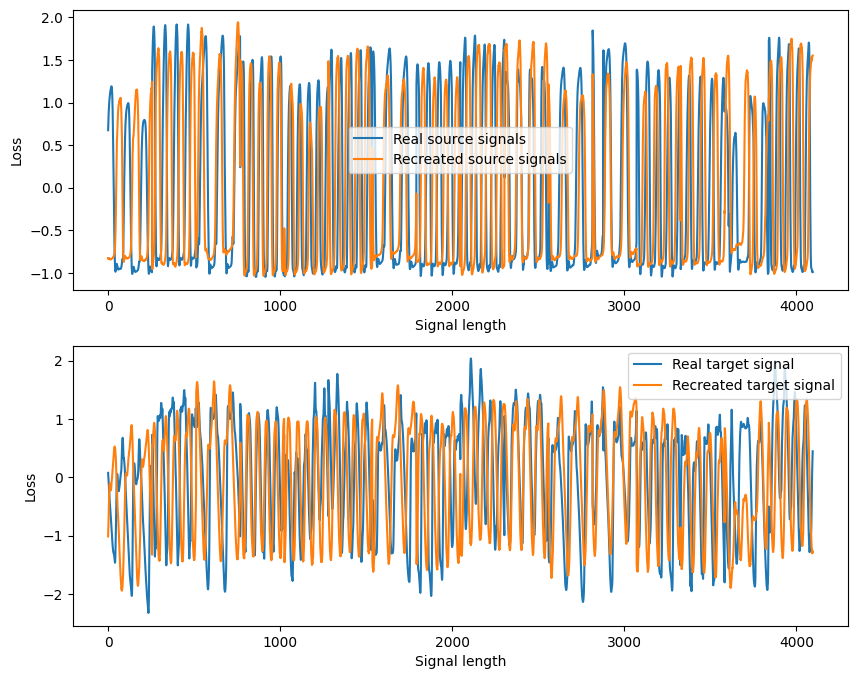

In [81]:
# Generate signals
idx = 0             
phases = df['Phasenzuordnung'].unique()
for source, target, source_phase, source_intervention, target_phase, target_intervention in test_loader:
    if idx == 5:
        break                 
                    
    source = source.float()
    target = target.float()
    source = source.to(DEVICE)
    target = target.to(DEVICE)
    source_phase = source_phase.to(DEVICE)
    source_intervention = source_intervention.to(DEVICE)
    target_phase = target_phase.to(DEVICE)
    target_intervention = target_intervention.to(DEVICE)

    # fake_target = gen_source(gen_target(source, source_phase, source_intervention, target_phase, target_intervention), source_phase, source_intervention, target_phase, target_intervention)
    # fake_source = gen_target(gen_source(target, source_phase, source_intervention, target_phase, target_intervention), source_phase, source_intervention, target_phase, target_intervention)

    fake_target = gen_target(source, source_phase, source_intervention, target_phase, target_intervention)
    fake_source = gen_source(target, source_phase, source_intervention, target_phase, target_intervention)
                        
    fake_target = fake_target.reshape(-1)
    fake_source = fake_source.reshape(-1)
    source = source.reshape(-1)
    target = target.reshape(-1)

    fig, ax = plt.subplots(2, 1, figsize=(10, 8))
    ax[0].plot(source.cpu().detach().numpy(), label= 'Real source signals')
    ax[0].plot(fake_source.cpu().detach().numpy(), label= 'Recreated source signals')
    ax[0].set_xlabel('Signal length')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    ax[1].plot(target.cpu().detach().numpy(), label= 'Real target signal')
    ax[1].plot(fake_target.cpu().detach().numpy(), label= 'Recreated target signal')
    ax[1].set_xlabel('Signal length')
    ax[1].set_ylabel('Loss')
    ax[1].legend()

    idx += 1       

In [82]:
# Verify L1 loss of reconstructed and real signals, per phase and intervention
# array([ 0.,  1.,  3., 10.,  2.,  4.,  9.])
# df of phase 1
df_phase_1 = df_test.loc[df_test['Phasenzuordnung'].isin([1])]
df_phase_2 = df_test.loc[df_test['Phasenzuordnung'].isin([2])]
df_phase_3 = df_test.loc[df_test['Phasenzuordnung'].isin([3])]
df_phase_4 = df_test.loc[df_test['Phasenzuordnung'].isin([4])]
df_phase_5 = df_test.loc[df_test['Phasenzuordnung'].isin([5])]

# 1.,  3., 10.,  2.,  4.
df_int_0 = df_test.loc[df_test['intervention'].isin([0])]
df_int_1 = df_test.loc[df_test['intervention'].isin([1])]
df_int_2 = df_test.loc[df_test['intervention'].isin([2])]
df_int_3 = df_test.loc[df_test['intervention'].isin([3])]
df_int_4 = df_test.loc[df_test['intervention'].isin([4])]
df_int_5 = df_test.loc[df_test['intervention'].isin([5])]
df_int_6 = df_test.loc[df_test['intervention'].isin([6])]

In [100]:
verify_dataset = AnimalDatasetEmbedding(df_int_6, source_signals, target_name = TARGET, window_length = WINDOW)
verify_loader = DataLoader(verify_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True,)

In [101]:
source_losses = []
target_losses = []

disc_source.eval()  # set discriminator to evaluation mode
disc_target.eval()  # turns off Dropouts Layers, BatchNorm Layers etc
gen_target.eval()
gen_source.eval()

for source, target, source_phase, source_intervention, target_phase, target_intervention in verify_loader:                
                    
    source = source.float()
    target = target.float()
    source = source.to(DEVICE)
    target = target.to(DEVICE)
    source_phase = source_phase.to(DEVICE)
    source_intervention = source_intervention.to(DEVICE)
    target_phase = target_phase.to(DEVICE)
    target_intervention = target_intervention.to(DEVICE)

    fake_target = gen_target(source, source_phase, source_intervention, target_phase, target_intervention)
    fake_source = gen_source(target, source_phase, source_intervention, target_phase, target_intervention)
    # source_reconstructed = gen_source(gen_target(source, source_phase, source_intervention, target_phase, target_intervention), source_phase, source_intervention, target_phase, target_intervention)
    # target_reconstructed = gen_target(gen_source(target, source_phase, source_intervention, target_phase, target_intervention), source_phase, source_intervention, target_phase, target_intervention)
    # l1_source = l1(source, fake_source)
    # l1_target = l1(target, fake_target)
    l1_source = l1(source, fake_source)
    l1_target = l1(target, fake_target)
    source_losses.append(l1_source.item())
    target_losses.append(l1_target.item())

print(f"Average L1 loss of source signals: {np.mean(source_losses)}")
print(f"Average L1 loss of target signals: {np.mean(target_losses)}")

# get min and max of losses
min_max_loss_source = np.min(source_losses), np.max(source_losses)
min_max_loss_target = np.min(target_losses), np.max(target_losses)
print(f"Min and max loss of source signals: {min_max_loss_source}")
print(f"Min and max loss of target signals: {min_max_loss_target}")

# get median of losses
median_loss_source = np.median(source_losses)
median_loss_target = np.median(target_losses)
print(f"Median loss of source signals: {median_loss_source}")
print(f"Median loss of target signals: {median_loss_target}")

Average L1 loss of source signals: 1.1882868111133575
Average L1 loss of target signals: 1.0809338688850403
Min and max loss of source signals: (1.111572265625, 1.3263510465621948)
Min and max loss of target signals: (0.9755849838256836, 1.253855586051941)
Median loss of source signals: 1.1597747802734375
Median loss of target signals: 1.0779380798339844


In [85]:
source_losses = []
target_losses = []

disc_source.eval()  # set discriminator to evaluation mode
disc_target.eval()  # turns off Dropouts Layers, BatchNorm Layers etc
gen_target.eval()
gen_source.eval()

for source, target, source_phase, source_intervention, target_phase, target_intervention in verify_loader:                
                    
    source = source.float()
    target = target.float()
    source = source.to(DEVICE)
    target = target.to(DEVICE)
    source_phase = source_phase.to(DEVICE)
    source_intervention = source_intervention.to(DEVICE)
    target_phase = target_phase.to(DEVICE)
    target_intervention = target_intervention.to(DEVICE)

    fake_target = gen_target(source, source_phase, source_intervention, target_phase, target_intervention)
    fake_source = gen_source(target, source_phase, source_intervention, target_phase, target_intervention)
    l1_source = l1(source, fake_source)
    l1_target = l1(target, fake_target)
    source_losses.append(l1_source.item())
    target_losses.append(l1_target.item())

print(f"Average L1 loss of source signals: {np.mean(source_losses)}")
print(f"Average L1 loss of target signals: {np.mean(target_losses)}")

# get min and max of losses
min_max_loss_source = np.min(source_losses), np.max(source_losses)
min_max_loss_target = np.min(target_losses), np.max(target_losses)
print(f"Min and max loss of source signals: {min_max_loss_source}")
print(f"Min and max loss of target signals: {min_max_loss_target}")

# get median of losses
median_loss_source = np.median(source_losses)
median_loss_target = np.median(target_losses)
print(f"Median loss of source signals: {median_loss_source}")
print(f"Median loss of target signals: {median_loss_target}")

Average L1 loss of source signals: 1.189625546336174
Average L1 loss of target signals: 1.0796064659953117
Min and max loss of source signals: (0.9132694005966187, 1.3781825304031372)
Min and max loss of target signals: (0.8619961142539978, 1.2494593858718872)
Median loss of source signals: 1.195171058177948
Median loss of target signals: 1.1287890672683716


In [86]:
# utils.save_checkpoint(gen_source, opt_gen, path="exp_2_all_data_gen_source.pth.tar")
# utils.save_checkpoint(gen_target, opt_gen, path="exp_2_all_data_gen_target.pth.tar")
# utils.save_checkpoint(disc_source, opt_disc, path="exp_2_all_data_disc_source.pth.tar")
# utils.save_checkpoint(disc_target, opt_disc, path="exp_2_all_data_disc_target.pth.tar")


In [87]:
# utils.load_checkpoint("Checkpoints/gen_source.pth.tar", gen_source, opt_gen, LEARNING_RATE)
# utils.load_checkpoint("Checkpoints/gen_target.pth.tar", gen_target, opt_gen, LEARNING_RATE)